In [2]:
# data_path = Path('data').glob('*')
# for i in data_path:
#     print(i)

data/allg.csv
data/10_groups.csv
data/bad_ids - bad_ids.csv.csv
data/product_groups.csv
data/09_groups.csv
data/11_groups.csv


In [12]:
# g_9 = pd.read_csv('data/09_groups.csv')
# g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [13]:
# g_10 = pd.read_csv('./data/10_groups.csv')
# g_10.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-10-01 20:22:55,2035558,0.0,1636749,52,339,1.0,107.90,0,10004
1,2020-10-01 20:54:12,13037327,0.0,267261,52,339,1.0,80.04,0,10004
2,2020-10-01 21:25:59,1430590,0.0,1331395,61,379,1.0,31.92,1,10091
3,2020-10-01 13:31:01,3504660,0.0,641525,61,97,1.0,55.98,0,10091
4,2020-10-01 16:32:06,11024438,0.0,1325852,61,97,4.0,176.00,0,10091


In [14]:
# g_11 = pd.read_csv('./data/11_groups.csv')
# g_11.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-11-01 15:29:01,3121751,0.0,332351,52,271,1.0,107.98,0,10004
1,2020-11-01 12:41:10,22047017,8293317.0,1875438,52,-9999,1.0,108.00,0,10004
2,2020-11-01 13:17:09,6419825,0.0,563112,61,379,2.0,112.00,0,10091
3,2020-11-01 12:31:31,10284541,0.0,1841710,61,379,1.0,55.91,0,10091
4,2020-11-01 13:06:15,10424967,0.0,1304277,61,271,2.0,87.80,0,10091


In [15]:
# p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
# p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [18]:
# g = pd.concat([g_9, g_10, g_11])

In [20]:
# print(f'len g before deleetion of bad ids {len(g)}')
# bad = pd.read_csv('data/bad_ids - bad_ids.csv.csv')
# g = g[~g['id_card'].isin(bad['id_card'])]
# print(f'len g after deleetion of bad ids {len(g)}')
# g.to_csv('data/allg.csv', index=False)

len g before deleetion of bad ids 134720639
len g after deleetion of bad ids 122718354


# Task 1

## H0: there is no dependency between avarage money spent in the order and buying discounted products  

## H1: there is some dependency

In [45]:
from scipy.stats import ttest_ind, pearsonr, f_oneway
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [20]:
%%time
# g = pd.read_csv('data/allg.csv')
g = pd.read_csv('data/09_groups.csv') # works 20 years, I gave up
print(len(g))
g.head()

42100858
CPU times: user 26.3 s, sys: 4.97 s, total: 31.3 s
Wall time: 37.8 s


,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [21]:
%%time
avg_spent = g[['sum', 'id_doc']].groupby("id_doc").mean()['sum'].to_list()

CPU times: user 5.84 s, sys: 276 ms, total: 6.12 s
Wall time: 6.11 s


In [22]:
%%time
sum_spent = g[['sum', 'id_doc']].groupby("id_doc").sum()['sum'].to_list()
# lets also try to check dependance on total order sum

CPU times: user 6.08 s, sys: 304 ms, total: 6.39 s
Wall time: 6.38 s


In [23]:
%%time
disc = np.array(g[['id_doc', 'is_green']].groupby("id_doc")['is_green'].sum().to_list())

CPU times: user 6.4 s, sys: 91.2 ms, total: 6.49 s
Wall time: 6.49 s


In [24]:
n = np.array(g[['sum', 'id_doc']].groupby("id_doc").count()['sum'].to_list())

In [25]:
%%time
disc_nrmd = disc / n

CPU times: user 20.4 ms, sys: 37 µs, total: 20.4 ms
Wall time: 19.7 ms


In [26]:
ttest_ind(avg_spent, disc_nrmd)

Ttest_indResult(statistic=4024.795575945475, pvalue=0.0)

reject H0

In [27]:
ttest_ind(sum_spent, disc_nrmd)

Ttest_indResult(statistic=2579.6329517009312, pvalue=0.0)

reject H0

we can run Pearson test to understand if dependance is direct or inverse

In [28]:
pearsonr(avg_spent, disc_nrmd)

(-0.14385746125694876, 0.0)

In [30]:
pearsonr(sum_spent, disc_nrmd)

(-0.1162956497020839, 0.0)

looks like inverse dependance

# Task 2

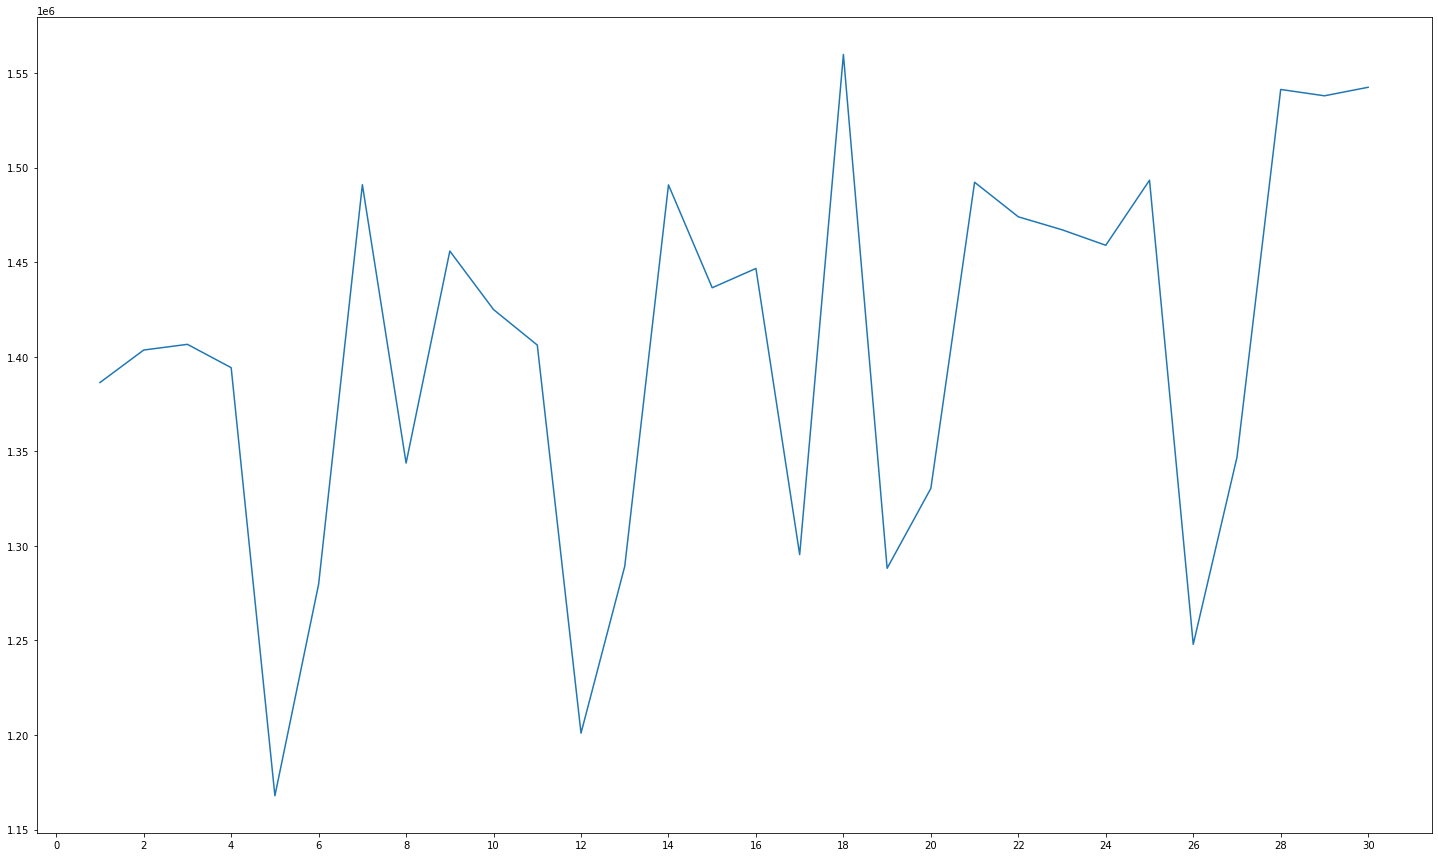

In [31]:
g.date = pd.to_datetime(g.date, format='%Y-%m-%d %H:%M:%S')
rpd = g.groupby(g.date.dt.day)['id_doc'].count()
plt.figure(figsize=(25, 15))
plt.locator_params(axis='x', nbins=31)
plt.plot(rpd)
plt.show()

looks like at 5th, 6th, 19th, 20th local minimums and then it increasesrpd

### lets ANOVA

## H0 : shopping in afterwage days same as all other days

## H1 : differnet

In [41]:
rpd

date
1     1386381
2     1403567
3     1406574
4     1394242
5     1167874
6     1279774
7     1490998
8     1343796
9     1455905
10    1424965
11    1406188
12    1200989
13    1289206
14    1490892
15    1436508
16    1446709
17    1295384
18    1559868
19    1288153
20    1330407
21    1492300
22    1474016
23    1467160
24    1458965
25    1493372
26    1247927
27    1346850
28    1541365
29    1538009
30    1542514
Name: id_doc, dtype: int64

In [40]:
rpd.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
           dtype='int64', name='date')

In [46]:
ad = rpd.index.to_list()
interesting, leftover = ad[0:6]+ad[19:26], ad[6:18] + ad[25:]
f_oneway(leftover, interesting)

F_onewayResult(statistic=0.8483356604781856, pvalue=0.3648917659121198)

p value big, fail to reject H0

# Task 3

## freq buyers

In [59]:
g = pd.read_csv('data/09_groups.csv')

In [63]:
g.date = pd.to_datetime(g.date, format='%Y-%m-%d %H:%M:%S')

Text(0, 0.5, 'Number of purchases')

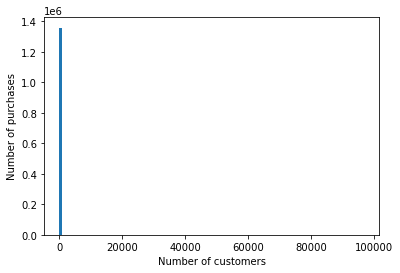

In [68]:
cr = df.groupby('id_card')['id_doc'].count()
plt.hist(cr, bins=100)
plt.xlabel('Number of customers')
plt.ylabel('Number of purchases')

Text(0, 0.5, 'Number of purchases')

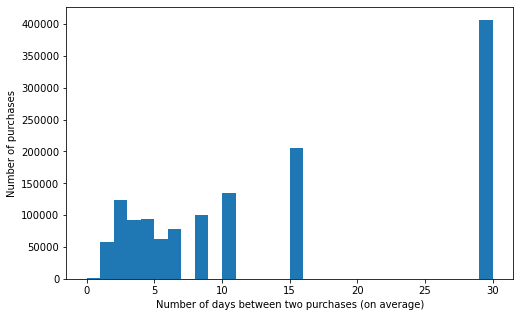

In [69]:
freqs = (1 / cr[cr > 0] * 30).round()

plt.figure(figsize=(8, 5))
plt.hist(freqs, bins=30)
plt.xlabel('Number of days between two purchases (on average)')
plt.ylabel('Number of purchases')

## Average purchase sum

In [70]:
aps = g.groupby('id_card')['sum'].sum()
aps.head()

id_card
0    3607.20
1     147.00
2    1485.00
3    4393.38
4    3905.12
Name: sum, dtype: float64

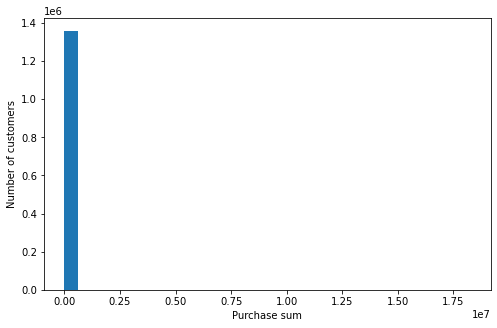

In [71]:
plt.figure(figsize=(8, 5))
plt.ylabel('Number of customers')
plt.xlabel('Purchase sum')
plt.hist(aps // 100 * 100, bins=30);

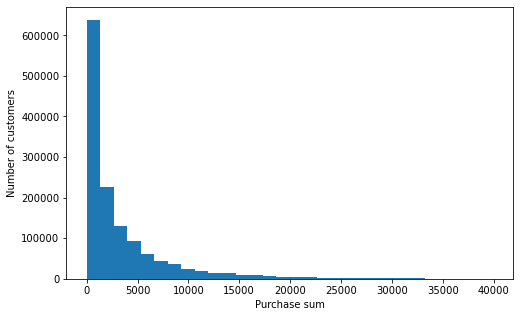

In [72]:
plt.figure(figsize=(8, 5))
plt.ylabel('Number of customers')
plt.xlabel('Purchase sum')
plt.hist(aps[aps < 40000] // 100 * 100, bins=30);

Most of the customers make purchases less than 1000 rubles



## Usual cart

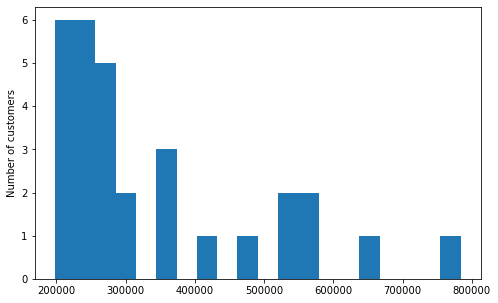

In [75]:
ccpg = g.groupby('id_group')['id_card'].unique().apply(len)

plt.figure(figsize=(8, 5))
plt.hist(ccpg.sort_values(ascending=False)[:30], bins=20)
plt.ylabel('Groups count')
plt.ylabel('Number of customers');

<AxesSubplot:xlabel='id_group'>

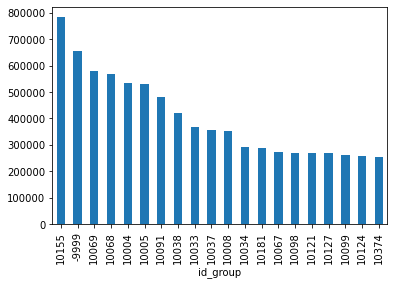

In [76]:
ccpg = g.groupby(by=['id_group'])['id_card'].unique().apply(len)
ccpg = ccpg.sort_values(ascending=False)
ccpg[:20].plot(kind='bar')

In [77]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [78]:
ig = p_g[p_g.id_group.isin(ccpg[:20].index)]
ig.drop_duplicates('id_group', 'first', inplace=True)
ig['occurence'] = ccpg[:20]
ig.sort_values('occurence', ascending=False)
ig[['id_group', 'name_group', 'occurence']].head()

/opt/conda/envs/torchok4/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/torchok4/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id_group,name_group,occurence
0,10004,Кисломолочные продукты,NaN
43,10005,Творог,NaN
93,10008,"Торты, пирожные, муссы, суфле",NaN
960,10033,"Выпечка, печенье, вафли, пряники",NaN
1032,10034,"Леденцы, мармелад, халва, зефир, восточные сла...",NaN


Most of the clients buy "Кисломолочные продукты"